In [238]:
import numpy as np 
import scipy as sp
from kak import *
from conditions import *
from qpd import *
import cirq 

In [216]:
#Cut single two-qubit gate in two qubit circuit
qc = cirq.Circuit()
qubits = cirq.LineQubit.range(2)
qc.append(cirq.H(qubits[0]))
qc.append(cirq.CNOT(qubits[0], qubits[1]))
print(qc)

0: ───H───@───
          │
1: ───H───X───


In [217]:
#decompose it in KAK-like decomposition
CX = cirq.unitary(cirq.CNOT)
u_cx = kak_like_decomposition(CX)
b_0 = cirq.MatrixGate(u_cx.single_qubit_operations_before[0],name='b_0')
b_1 = cirq.MatrixGate(u_cx.single_qubit_operations_before[1],name='b_1')
a_0 = cirq.MatrixGate(u_cx.single_qubit_operations_after[0], name='a_0')
a_1 = cirq.MatrixGate(u_cx.single_qubit_operations_after[1], name='a_1')

In [221]:
#initialize ancillas
anc_0 = cirq.NamedQubit('anc_0')
anc_1 = cirq.NamedQubit('anc_1')
#make cirq gates from unitaries
b_0 = cirq.MatrixGate(u_cx.single_qubit_operations_before[0],name='b_0')
b_1 = cirq.MatrixGate(u_cx.single_qubit_operations_before[1],name='b_1')
a_0 = cirq.MatrixGate(u_cx.single_qubit_operations_after[0], name='a_0')
a_1 = cirq.MatrixGate(u_cx.single_qubit_operations_after[1], name='a_1')
#initialize local gates from interaction part of KAK-like
l = [cirq.I, cirq.X, cirq.Y, cirq.Z]
#create empty list of subcircuits and weights
subcircuits = []
weights = []
u = u_cx.amplitudes
for i in range(len(u)):
    u_w = np.abs(u[i]) 
    phi = np.angle(u[i])
    subcirc = qc.copy()
    subcirc.batch_remove([(1,cirq.CNOT(qubits[0],qubits[1]))])
    subcirc.insert(1, cirq.Moment([b_0(qubits[0]),b_1(qubits[1])]))
    subcirc.insert(2, cirq.Moment([l[i](qubits[0]),l[i](qubits[1])]))
    subcirc.insert(3, cirq.Moment([a_0(qubits[0]),a_1(qubits[1])]))
    weights.append(u_w)
    subcircuits.append(subcirc)

In [223]:
#initialize ancillas
anc_0 = cirq.NamedQubit('anc_0')
anc_1 = cirq.NamedQubit('anc_1')
#make cirq gates from unitaries
b_0 = cirq.MatrixGate(u_cx.single_qubit_operations_before[0],name='b_0')
b_1 = cirq.MatrixGate(u_cx.single_qubit_operations_before[1],name='b_1')
a_0 = cirq.MatrixGate(u_cx.single_qubit_operations_after[0], name='a_0')
a_1 = cirq.MatrixGate(u_cx.single_qubit_operations_after[1], name='a_1')
#initialize local gates from interaction part of KAK-like
l = [cirq.I, cirq.X, cirq.Y, cirq.Z]
#create empty list of subcircuits and weights
subcircuits = []
weights = []
u = u_cx.amplitudes #list of amplitudes in KAK-like decomposition
#append simple gates with corresponding weights
for i in range(len(u)):
    u_w = np.abs(u[i]) 
    phi = np.angle(u[i])
    subcirc = qc.copy()
    subcirc.batch_remove([(1,cirq.CNOT(qubits[0],qubits[1]))])
    qpd_channel = simple_subcircuit(qubits[0], qubits[1],
                                    l[i],
                                    a_0, a_1,
                                    b_0, b_1)
    subcirc.insert(1, qpd_channel)    
    weights.append(u_w)
    subcircuits.append(subcirc)
#append subcircuits with ancilla
for i in range(len(u)):
    for j in range(i+1, len(u)):
        u_w = 2 * np.abs(u[i]) * np.abs(u[j])
        phi = np.angle(u[i]) - np.angle(u[j])
        subcirc = qc.copy()
        subcirc.batch_remove([(1,cirq.CNOT(qubits[0],qubits[1]))])
        subcirc.insert(1, ancilla_subcirc(qubits[0], qubits[1], 
                                          anc_0, anc_1,
                                          b_0, b_1,
                                          a_0, a_1, 
                                          phi, 
                                          local_i=l[i], 
                                          local_j=l[j]))
        weights.append(u_w)
        subcircuits.append(subcirc)
#append subcircuits with ancillas and phase shift
for i in range(len(u)):
    for j in range(i+1, len(u)):
        u_w = -2 * np.abs(u[i]) * np.abs(u[j])
        phi = np.angle(u[i]) - np.angle(u[j]) + np.pi
        subcirc = qc.copy()
        subcirc.batch_remove([(1,cirq.CNOT(qubits[0],qubits[1]))])
        subcirc.insert(1,ancilla_subcirc(qubits[0], qubits[1], 
                                          anc_0, anc_1, 
                                          b_0, b_1,
                                          a_0, a_1,
                                          phi, 
                                          local_i=l[i], 
                                          local_j=l[j]))
        weights.append(u_w)
        subcircuits.append(subcirc)

In [239]:
#Pay attention that weight is not correct because sign of some weights
#depends on measurement outcome on ancillas and can't be found before simulation
#However these weights can be used to construct dustribution to sample from
distribution_to_sample = np.abs(weights) / np.linalg.norm(weights,1)

In [246]:
print("number of subcircuits =", len(subcircuits))
for _ in subcircuits[0:5]:
    print(_)

number of subcircuits = 16
0: ───H───b_0───I───a_0───────

1: ───H───b_1───I───a_1───────
0: ───H───b_0───X───a_0───────

1: ───H───b_1───X───a_1───────
0: ───H───b_0───Y───a_0───────

1: ───H───b_1───Y───a_1───────
0: ───H───b_0───Z───a_0───────

1: ───H───b_1───Z───a_1───────
                                       ┌──┐       ┌──┐
0: ───────H───b_0───────────────────────I──────────X─────a_0───────
                                        │          │
1: ───────H───b_1───────────────────────┼I─────────┼X────a_1───────
                                        ││         ││
anc_0: ───────R─────H───phi=0.79───X────@┼────X────@┼────H─────────
                                         │          │
anc_1: ───────R─────H───phi=0.79───X─────@────X─────@────H─────────
                                       └──┘       └──┘


To do list:
1. Научиться нормально симулировать серкиты и обрабатывать результаты в cirq.
 
В cirq результаты симуляции содержатся в экземпляре класса ResultDict
print(result)  выводит последовательность измеренных кубитов и последовательность соответствующих им исходов измерения


In [247]:
simulator = cirq.Simulator()
circuit_to_run = subcircuits[np.random.choice(len(distribution_to_sample), p=distribution_to_sample)].copy()
circuit_to_run.append(cirq.measure(circuit_to_run.all_qubits()))
result = simulator.run(circuit_to_run)
print(result)


q(0),q(1),anc_1,anc_0=0, 0, 1, 0


Если исполнить цепочку немколько раз, то для каждого кубита будет выводиться последователньность полученных в каждом "шоте" значений

In [250]:
result = simulator.run(circuit_to_run, repetitions= 10)
print(result)

q(0),q(1),anc_1,anc_0=0110001000, 1101100011, 1101111111, 1110001010


Битстринги содержатся в словаре measurements

In [257]:
result.measurements

{'q(0),q(1),anc_1,anc_0': array([[0, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 0, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 0],
        [0, 0, 1, 0],
        [1, 0, 1, 1],
        [0, 0, 1, 0],
        [0, 1, 1, 1],
        [0, 1, 1, 0]], dtype=uint8)}

c:\Users\densd\circuit-cutting\.venv\lib\site-packages\cirq\vis\state_histogram.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'Result State Histogram'}, xlabel='qubit state', ylabel='result count'>

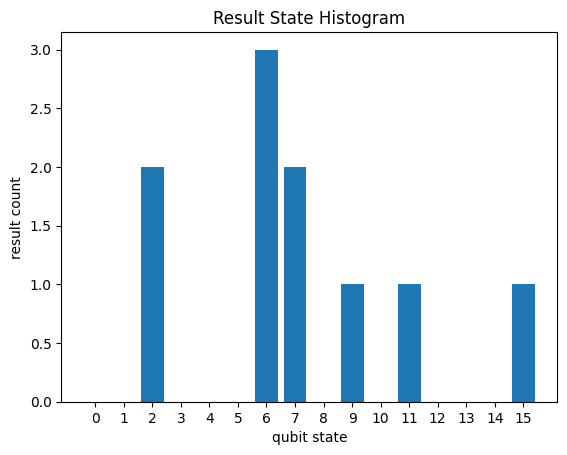

In [261]:
cirq.plot_state_histogram(result)

Надо научиться в цикле сэмплить цепочку из распределения вероятностей, исполнять, запоминать битстринг и вес, с которым он будет учитываться при восстановлении распределения вероятностей по битстрингам. То есть надо запоминать вес серкита и выходной битстринг 
Хранить скорее всего удобно как список кортежей $[(bitstring, weight)]$


2. Научиться резать полученные подцепочки на две части.
Circuit cutting нужен для того, чтобы исполнять большие цепочки на малом числе кубитов. Для этого надо полученные подцепочки в квазивероятностном разложении действительно разделить на две части по линии разреза (индексу кубита в цепочке)

Вопрос: как реализовать в коде такую функцию, которая будет на вход принимать цепочку и индекс, по которому цепочка режется, а на выход выдавать две цепочки: цепочку для подсистемы А и соответствующей ей анциллы и цепочку для подсистемы В и соответствующуй ей анциллы.

Ниже попытка реализовать такую функцию.

In [262]:
print(circuit_to_run[:-1])

                                        ┌──┐       ┌──┐
0: ───────H───b_0────────────────────────I──────────X─────a_0───
                                         │          │
1: ───────H───b_1────────────────────────┼I─────────┼X────a_1───
                                         ││         ││
anc_0: ───────R─────H───phi=-0.79───X────@┼────X────@┼────H─────
                                          │          │
anc_1: ───────R─────H───phi=-0.79───X─────@────X─────@────H─────
                                        └──┘       └──┘


In [264]:
def split_circuit(circuit, qubits, ancillas, index):
  """Splits a circuit into two subcircuits based on a given index.

  Args:
    circuit: The original circuit to split.
    qubits: A list of basic qubits in the circuit.
    ancillas: A list of ancilla qubits in the circuit.
    index: The index at which to split the circuit.

  Returns:
    A tuple containing two subcircuits: subcircuit1 and subcircuit2.
  """

  subcircuit1 = cirq.Circuit()
  subcircuit2 = cirq.Circuit()

  # Assign ancillas to subcircuits
  subcircuit1_ancillas = [ancillas[0]]  # anc_0 goes to subcircuit1
  subcircuit2_ancillas = [ancillas[1]]  # anc_1 goes to subcircuit2

  # Define connected sets
  connected_qubits1 = set(qubits[:index]) | set(subcircuit1_ancillas)
  connected_qubits2 = set(qubits[index:]) | set(subcircuit2_ancillas)

  for moment in circuit:
    for operation in moment:
      if isinstance(operation, cirq.GateOperation):
        # Check if the operation involves any of the connected qubits
        if any(q in connected_qubits1 for q in operation.qubits):
          subcircuit1.append(operation)
        elif any(q in connected_qubits2 for q in operation.qubits):
          subcircuit2.append(operation)
        else:
          # Operation involves qubits from both subcircuits, it's not in either
          pass
      else:
        # Operation is not a GateOperation (e.g., measurement), add it to the appropriate subcircuit
        if any(q in connected_qubits1 for q in operation.qubits):
          subcircuit1.append(operation)
        elif any(q in connected_qubits2 for q in operation.qubits):
          subcircuit2.append(operation)

  return subcircuit1, subcircuit2

In [265]:
c1, c2 = split_circuit(circuit_to_run[:-1], qubits, [anc_0, anc_1], 1)
print(c1)
print('\n')
print(c2)

0: ───────H───b_0───────────────────I───────X───a_0───
                                    │       │
anc_0: ───R───H─────phi=-0.79───X───@───X───@───H─────


1: ───────H───b_1───────────────────I───────X───a_1───
                                    │       │
anc_1: ───R───H─────phi=-0.79───X───@───X───@───H─────


3. Автоматизировать разрез цепочек для произвольных цепочек с множеством кубитов по паре кубитов, между которыми только одна нелокальная операция.

4. Научиться делать разрез цепочек, когда между подсистемами А и В есть несколько двухкубитных гейтов (которые могут в общем случае действовать на разные кубиты этих подсистем)

5. Автоматизировать разрез многокубитных цепочек. Реализовать код, который для произвольной цепочки выдаст оптимальный разрез по совокупному гамма-фактору. 